# 实践题一
# 1）实现一个三层神经网络，并使用iris数据集前80%训练、后20%测试，要求测试错误率小于5%，分析至少三种非线性激活函数的影响。

In [1]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 使用pytorch库实现三层神经网络
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
torch.manual_seed(0)

In [2]:
# 将特征变量和标签分开并打乱数据集
def shuffle_data(data, label):
    index = np.arange(len(label))
    np.random.shuffle(index)
    data = data[index, :]
    label = label[index]
    return data, label

In [3]:
# 读取Iris数据集
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class']
iris_df = pd.read_csv('iris.data', names=names)
iris_df.head()
iris_data = iris_df.values[:,:-1].astype(np.float)
# 三类鸢尾花分别编号为 0，1，2
iris_label = pd.Categorical(iris_df['class']).codes.astype(np.float)

In [4]:
# 划分80%训练数据和20%测试数据
def train_test_divide(data, label, proportion):
    """
        proportion: range from 0 to 1, means the proportion of training data in the total data
    """
    train_length = int(len(label)*proportion)
    train_data = data[:train_length, :]
    train_label = label[:train_length]
    test_data = data[train_length:, :]
    test_label = label[train_length:]
    # 显示数据量及特征维度
    print("Shape: train_data", train_data.shape,
          "|train_label", train_label.shape,
          "|test_data", test_data.shape,
          "|test_label", test_label.shape)
    
    return train_data, train_label, test_data, test_label

# 使用pytorch定义三层神经网络
## 输入层维度为4，隐藏层维度为11，输出层维度为3
![img](./img/FNN架构.JPG)

In [5]:
class FNN(nn.Module):
    def __init__(self, input_size, output_size, activation_f):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 12)   # input input_size;  output 10
        self.fc2 = nn.Linear(12, output_size)  # input 5;           output output_size
        self.activation_f = activation_f
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation_f(x)
        x = self.fc2(x)
        
        return x
    
    def predict(self, x):
        x = self.fc1(x)
        x = self.activation_f(x)
        x = self.fc2(x)
        
        _, pred = torch.max(x.data, 1)
        return pred

# 定义训练类

In [6]:
class training_process:
    def __init__(self, train_data, train_label, test_data, test_label, model, criterion, optimizer,
                  epoch=10):
        """
            train_data: 训练数据
            train_label: 训练数据标签
            test_data: 测试数据
            test_label: 测试数据标签
            model: 使用的模型
            criterion: 损失函数
            optimizer: 优化方法
            epoch: 训练轮数
        """
        self.train_data = train_data
        self.train_label = train_label
        self.test_data = test_data
        self.test_label = test_label
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_size = len(train_label)
        self.test_size = len(test_label)
        self.epoch = epoch
        
        # 用来保存每次训练过程中训练集误差、测试集误差、训练集精度以及测试集精度
        self.loss_train = []
        self.loss_test = []
        self.acc_train = []
        self.acc_test = []
    
    # 清空已有的训练过程
    def clear(self):
        self.loss_train = []
        self.loss_test = []
        self.acc_train = []
        self.acc_test = []
        
    # 输出训练过程数据
    def checkpoint(self):
        return self.loss_train, self.loss_test, self.acc_train, self.acc_test
    
    # 定义训练过程
    def train(self):
        for epoch in tqdm(range(self.epoch)):
            # 清优化器梯度
            self.optimizer.zero_grad()
            # 正向传播计算误差
            train_outputs = self.model(self.train_data)
            train_loss = self.criterion(train_outputs, self.train_label)
            # 反向传播计算梯度
            train_loss.backward()
            # 优化器更新模型参数
            self.optimizer.step()

            self.loss_train.append(train_loss)
            # 测试模型在训练集和测试集上的精度以及计算在测试集上的loss
            train_correct = 0
            test_correct = 0
            with torch.no_grad():
                test_outputs = self.model(self.test_data)
                test_loss = self.criterion(test_outputs, self.test_label)
                
                train_predicted = self.model.predict(self.train_data)
                train_correct += (train_predicted == self.train_label).sum().item()

                test_predicted = self.model.predict(self.test_data)
                test_correct += (test_predicted == self.test_label).sum().item()
                
                    
            self.acc_train.append(train_correct/self.train_size*100)
            self.acc_test.append(test_correct/self.test_size*100)
            self.loss_test.append(test_loss)
            # 打印训练过程信息
            print('[epoch: %d]|training loss: %.6f| testing loss: %.6f' %
             (epoch + 1, train_loss, test_loss))
            print('Accuracy of the network on the train data: %.3f %%' % (train_correct/self.train_size*100)) 
            print('Accuracy of the network on the test data: %.3f %%' % (test_correct/self.test_size*100))

        print('Finished Training')
      
    # 作出四张图，分别是训练集误差曲线、测试集误差曲线、训练集精度曲线、测试集精度曲线
    def plot_loss_and_acc(self, figname):
        fig = plt.figure(figsize=(10, 16))
        # 训练集和测试集误差曲线
        ax1 = fig.add_subplot(211)
        ax1.plot(np.arange(self.epoch)+1, np.array(self.loss_train))
        ax1.plot(np.arange(self.epoch)+1, np.array(self.loss_test))
        ax1.set_xlabel('Steps')
        ax1.set_ylabel('Loss')
        ax1.set_title('Loss of the network on the training and testing data')
        ax1.legend(['Train', 'Test'])
        ax1.grid(True)

        # 训练集和测试集精度曲线
        ax2 = fig.add_subplot(212)
        ax2.plot(np.arange(self.epoch)+1, np.array(self.acc_train))
        ax2.plot(np.arange(self.epoch)+1, np.array(self.acc_test))
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Accuracy of the network on the training and testing data')
        ax2.legend(['Train', 'Test'])
        ax2.grid(True)
        
        plt.savefig('./img/%s_loss_acc.png' % figname)
        plt.show()

# 预处理数据集
## 训练集测试集划分、输入归一化以及tensor封装

In [7]:
# 打乱数据集并进行80%训练和20%测试划分
iris_data, iris_label = shuffle_data(iris_data, iris_label)
train_data, train_label, test_data, test_label = train_test_divide(iris_data, iris_label, 0.8)
# 计算训练集数据均值和方差
train_mean = np.mean(train_data, axis=0)
train_std = np.std(train_data, axis=0)
# 预处理数据
train_data = (train_data - train_mean)/train_std
test_data = (test_data - train_mean)/train_std

train_data = torch.tensor(train_data, dtype=torch.float32)
train_label = torch.tensor(train_label, dtype=torch.long)
test_data = torch.tensor(test_data, dtype=torch.float32)
test_label = torch.tensor(test_label, dtype=torch.long)

Shape: train_data (120, 4) |train_label (120,) |test_data (30, 4) |test_label (30,)


# 完成模型和训练过程定义后，分别使用三种非线性激活函数进行训练和测试
### 在此我采用四种非线性激活函数分别为{relu, elu, tanh, sigmoid}

# ReLU
![img](./img/ReLU.png)

 83%|██████████████████████████████████████████████████████████████████▍             | 83/100 [00:00<00:00, 406.34it/s]

[epoch: 1]|training loss: 1.205048| testing loss: 1.181465
Accuracy of the network on the train data: 30.000 %
Accuracy of the network on the test data: 13.333 %
[epoch: 2]|training loss: 1.127721| testing loss: 1.106594
Accuracy of the network on the train data: 54.167 %
Accuracy of the network on the test data: 36.667 %
[epoch: 3]|training loss: 1.055279| testing loss: 1.037227
Accuracy of the network on the train data: 61.667 %
Accuracy of the network on the test data: 36.667 %
[epoch: 4]|training loss: 0.987703| testing loss: 0.972784
Accuracy of the network on the train data: 65.833 %
Accuracy of the network on the test data: 60.000 %
[epoch: 5]|training loss: 0.925449| testing loss: 0.911133
Accuracy of the network on the train data: 66.667 %
Accuracy of the network on the test data: 63.333 %
[epoch: 6]|training loss: 0.868299| testing loss: 0.853157
Accuracy of the network on the train data: 66.667 %
Accuracy of the network on the test data: 66.667 %
[epoch: 7]|training loss: 0.

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 407.48it/s]


[epoch: 84]|training loss: 0.076408| testing loss: 0.057032
Accuracy of the network on the train data: 96.667 %
Accuracy of the network on the test data: 100.000 %
[epoch: 85]|training loss: 0.075548| testing loss: 0.055737
Accuracy of the network on the train data: 96.667 %
Accuracy of the network on the test data: 100.000 %
[epoch: 86]|training loss: 0.074714| testing loss: 0.054488
Accuracy of the network on the train data: 96.667 %
Accuracy of the network on the test data: 100.000 %
[epoch: 87]|training loss: 0.073907| testing loss: 0.053290
Accuracy of the network on the train data: 96.667 %
Accuracy of the network on the test data: 100.000 %
[epoch: 88]|training loss: 0.073126| testing loss: 0.052142
Accuracy of the network on the train data: 96.667 %
Accuracy of the network on the test data: 100.000 %
[epoch: 89]|training loss: 0.072381| testing loss: 0.051044
Accuracy of the network on the train data: 96.667 %
Accuracy of the network on the test data: 100.000 %
[epoch: 90]|trai

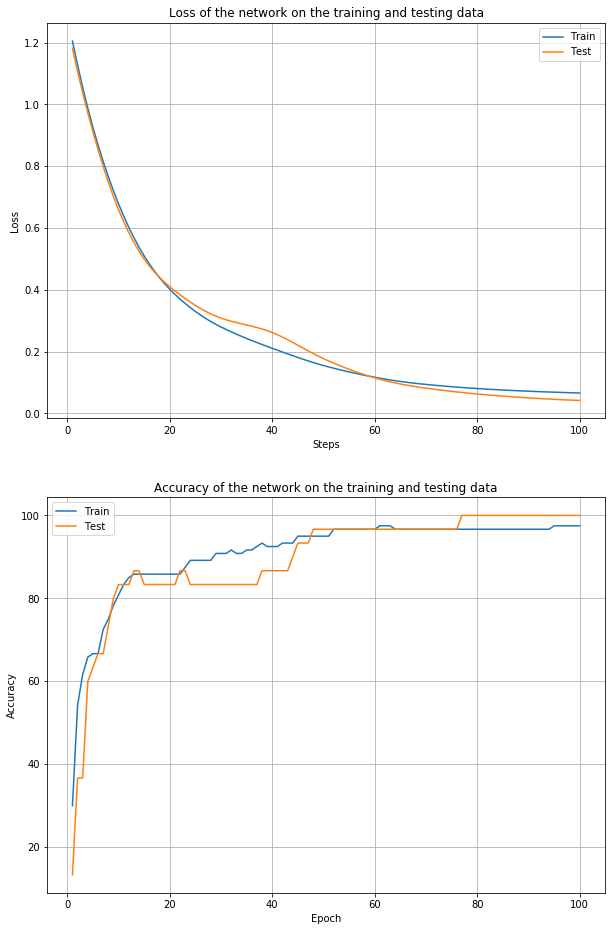

In [12]:
# 使用relu作为非线性激活函数
fnn1 = FNN(train_data.shape[1], 3, F.relu)
criterion = nn.CrossEntropyLoss()  # 使用交叉熵损失函数
optimizer = optim.Adam(fnn1.parameters(), lr=0.015)  # 使用Adam优化器

training1 = training_process(train_data, train_label, test_data, test_label, fnn1, criterion, optimizer,
                  epoch=100)
training1.train()
training1.plot_loss_and_acc('ReLU')

# ELU
![img](./img/ELU.png)

 77%|█████████████████████████████████████████████████████████████▌                  | 77/100 [00:00<00:00, 369.91it/s]

[epoch: 1]|training loss: 1.148393| testing loss: 0.971278
Accuracy of the network on the train data: 30.833 %
Accuracy of the network on the test data: 50.000 %
[epoch: 2]|training loss: 1.077874| testing loss: 0.913790
Accuracy of the network on the train data: 32.500 %
Accuracy of the network on the test data: 53.333 %
[epoch: 3]|training loss: 1.013683| testing loss: 0.861585
Accuracy of the network on the train data: 38.333 %
Accuracy of the network on the test data: 56.667 %
[epoch: 4]|training loss: 0.955221| testing loss: 0.814023
Accuracy of the network on the train data: 45.833 %
Accuracy of the network on the test data: 60.000 %
[epoch: 5]|training loss: 0.901859| testing loss: 0.770486
Accuracy of the network on the train data: 50.000 %
Accuracy of the network on the test data: 73.333 %
[epoch: 6]|training loss: 0.853033| testing loss: 0.730444
Accuracy of the network on the train data: 62.500 %
Accuracy of the network on the test data: 80.000 %
[epoch: 7]|training loss: 0.

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 378.00it/s]


[epoch: 78]|training loss: 0.089810| testing loss: 0.068104
Accuracy of the network on the train data: 97.500 %
Accuracy of the network on the test data: 100.000 %
[epoch: 79]|training loss: 0.088259| testing loss: 0.066013
Accuracy of the network on the train data: 97.500 %
Accuracy of the network on the test data: 100.000 %
[epoch: 80]|training loss: 0.086781| testing loss: 0.064023
Accuracy of the network on the train data: 97.500 %
Accuracy of the network on the test data: 100.000 %
[epoch: 81]|training loss: 0.085373| testing loss: 0.062132
Accuracy of the network on the train data: 97.500 %
Accuracy of the network on the test data: 100.000 %
[epoch: 82]|training loss: 0.084034| testing loss: 0.060335
Accuracy of the network on the train data: 97.500 %
Accuracy of the network on the test data: 100.000 %
[epoch: 83]|training loss: 0.082759| testing loss: 0.058628
Accuracy of the network on the train data: 97.500 %
Accuracy of the network on the test data: 100.000 %
[epoch: 84]|trai

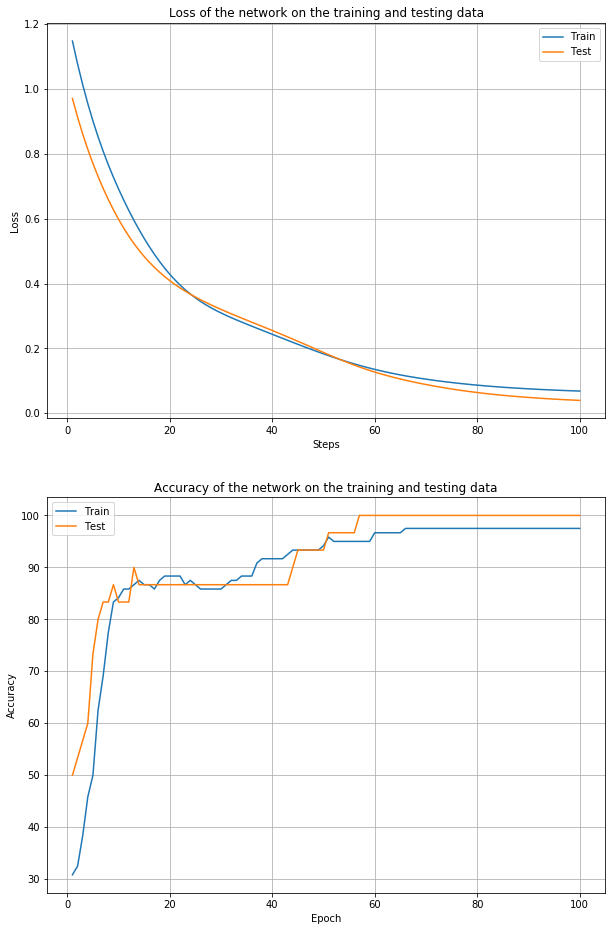

In [18]:
# 使用elu作为非线性激活函数
fnn2 = FNN(train_data.shape[1], 3, F.elu)
criterion = nn.CrossEntropyLoss()  # 使用交叉熵损失函数
optimizer = optim.Adam(fnn2.parameters(), lr=0.011)  # 使用Adam优化器

training2 = training_process(train_data, train_label, test_data, test_label, fnn2, criterion, optimizer,
                  epoch=100)
training2.train()
training2.plot_loss_and_acc('ELU')

# Tanh
![img](./img/Tanh.png)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]E:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
 76%|████████████████████████████████████████████████████████████▊                   | 76/100 [00:00<00:00, 347.17it/s]

[epoch: 1]|training loss: 1.150868| testing loss: 1.122043
Accuracy of the network on the train data: 30.000 %
Accuracy of the network on the test data: 26.667 %
[epoch: 2]|training loss: 1.100432| testing loss: 1.073940
Accuracy of the network on the train data: 58.333 %
Accuracy of the network on the test data: 40.000 %
[epoch: 3]|training loss: 1.053113| testing loss: 1.028780
Accuracy of the network on the train data: 70.000 %
Accuracy of the network on the test data: 66.667 %
[epoch: 4]|training loss: 1.008239| testing loss: 0.985433
Accuracy of the network on the train data: 71.667 %
Accuracy of the network on the test data: 63.333 %
[epoch: 5]|training loss: 0.965308| testing loss: 0.943167
Accuracy of the network on the train data: 75.833 %
Accuracy of the network on the test data: 70.000 %
[epoch: 6]|training loss: 0.923868| testing loss: 0.901544
Accuracy of the network on the train data: 80.000 %
Accuracy of the network on the test data: 73.333 %
[epoch: 7]|training loss: 0.

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 383.05it/s]


[epoch: 78]|training loss: 0.102793| testing loss: 0.079037
Accuracy of the network on the train data: 96.667 %
Accuracy of the network on the test data: 100.000 %
[epoch: 79]|training loss: 0.101162| testing loss: 0.076884
Accuracy of the network on the train data: 97.500 %
Accuracy of the network on the test data: 100.000 %
[epoch: 80]|training loss: 0.099597| testing loss: 0.074803
Accuracy of the network on the train data: 97.500 %
Accuracy of the network on the test data: 100.000 %
[epoch: 81]|training loss: 0.098096| testing loss: 0.072794
Accuracy of the network on the train data: 97.500 %
Accuracy of the network on the test data: 100.000 %
[epoch: 82]|training loss: 0.096656| testing loss: 0.070856
Accuracy of the network on the train data: 97.500 %
Accuracy of the network on the test data: 100.000 %
[epoch: 83]|training loss: 0.095274| testing loss: 0.068989
Accuracy of the network on the train data: 97.500 %
Accuracy of the network on the test data: 100.000 %
[epoch: 84]|trai

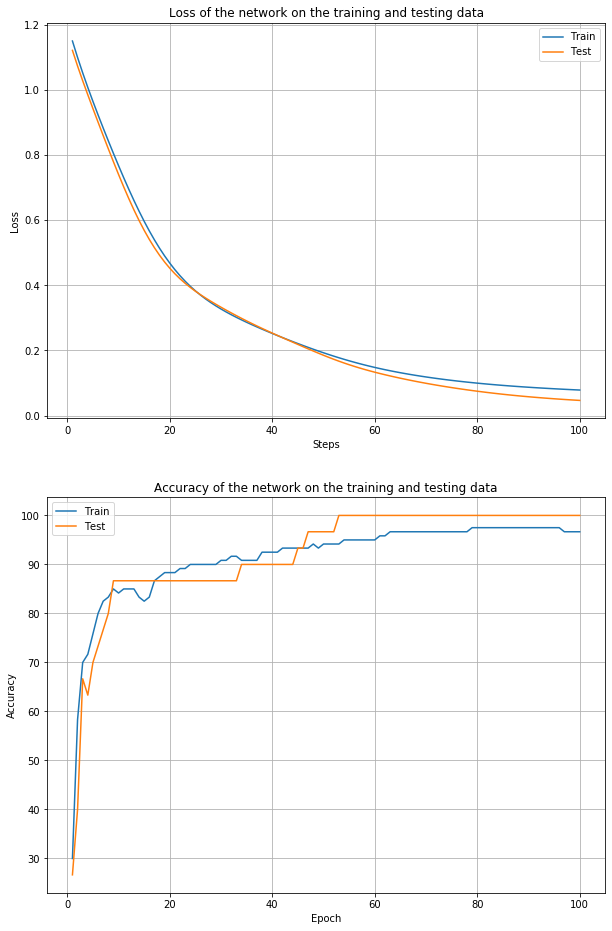

In [10]:
# 使用Tanh作为非线性激活函数
fnn3 = FNN(train_data.shape[1], 3, F.tanh)
criterion = nn.CrossEntropyLoss()  # 使用交叉熵损失函数
optimizer = optim.Adam(fnn3.parameters(), lr=0.011)  # 使用Adam优化器

training3 = training_process(train_data, train_label, test_data, test_label, fnn3, criterion, optimizer,
                  epoch=100)
training3.train()
training3.plot_loss_and_acc('Tanh')

# Sigmoid
![img](./img/Sigmoid.png)

  0%|                                                                                          | 0/150 [00:00<?, ?it/s]E:\Anaconda\envs\pytorch\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
 30%|████████████████████████                                                        | 45/150 [00:00<00:00, 437.97it/s]

[epoch: 1]|training loss: 1.185550| testing loss: 1.217824
Accuracy of the network on the train data: 35.833 %
Accuracy of the network on the test data: 23.333 %
[epoch: 2]|training loss: 1.143732| testing loss: 1.166377
Accuracy of the network on the train data: 35.000 %
Accuracy of the network on the test data: 23.333 %
[epoch: 3]|training loss: 1.113520| testing loss: 1.126660
Accuracy of the network on the train data: 32.500 %
Accuracy of the network on the test data: 23.333 %
[epoch: 4]|training loss: 1.090551| testing loss: 1.094086
Accuracy of the network on the train data: 23.333 %
Accuracy of the network on the test data: 16.667 %
[epoch: 5]|training loss: 1.070558| testing loss: 1.065714
Accuracy of the network on the train data: 28.333 %
Accuracy of the network on the test data: 23.333 %
[epoch: 6]|training loss: 1.051048| testing loss: 1.040017
Accuracy of the network on the train data: 31.667 %
Accuracy of the network on the test data: 26.667 %
[epoch: 7]|training loss: 1.

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 432.32it/s]

[epoch: 90]|training loss: 0.194373| testing loss: 0.202037
Accuracy of the network on the train data: 96.667 %
Accuracy of the network on the test data: 93.333 %
[epoch: 91]|training loss: 0.191472| testing loss: 0.198619
Accuracy of the network on the train data: 96.667 %
Accuracy of the network on the test data: 93.333 %
[epoch: 92]|training loss: 0.188618| testing loss: 0.195244
Accuracy of the network on the train data: 96.667 %
Accuracy of the network on the test data: 93.333 %
[epoch: 93]|training loss: 0.185811| testing loss: 0.191915
Accuracy of the network on the train data: 96.667 %
Accuracy of the network on the test data: 93.333 %
[epoch: 94]|training loss: 0.183051| testing loss: 0.188634
Accuracy of the network on the train data: 96.667 %
Accuracy of the network on the test data: 93.333 %
[epoch: 95]|training loss: 0.180340| testing loss: 0.185399
Accuracy of the network on the train data: 95.833 %
Accuracy of the network on the test data: 93.333 %
[epoch: 96]|training l

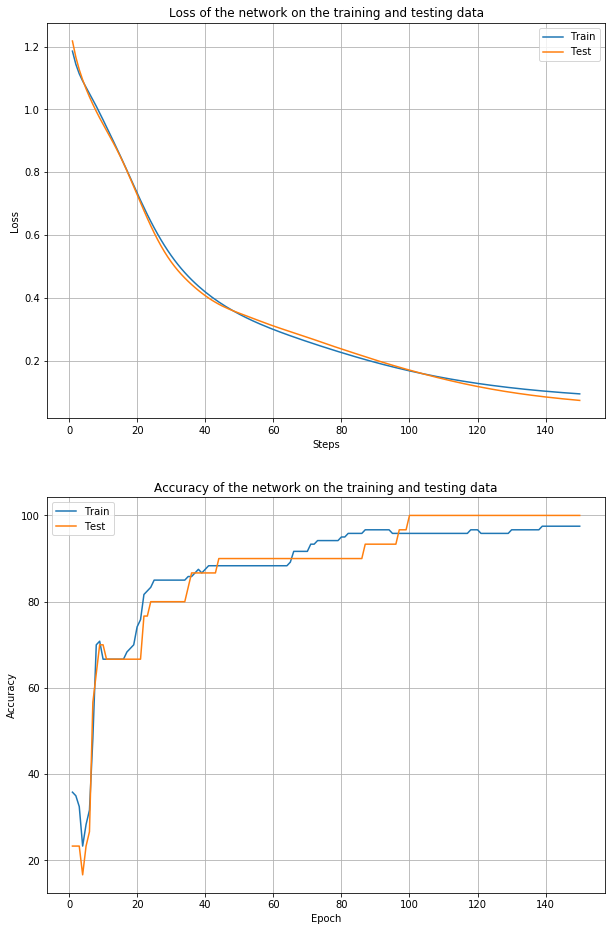

In [11]:
# 使用Sigmoid作为非线性激活函数
fnn4 = FNN(train_data.shape[1], 3, F.sigmoid)
criterion = nn.CrossEntropyLoss()  # 使用交叉熵损失函数
optimizer = optim.Adam(fnn4.parameters(), lr=0.015)  # 使用Adam优化器

training4 = training_process(train_data, train_label, test_data, test_label, fnn4, criterion, optimizer,
                  epoch=150)
training4.train()
training4.plot_loss_and_acc('Sigmoid')

# 通过调整四种激活函数的参数，最终使用{ReLU、ELU、Tanh、Sigmoid}四种激活函数均在iris数据集上取得了100%的测试正确率。
# 这四者还是有很大区别的：
## Sigmoid：Sigmoid函数饱和会导致梯度消失，当神经元的激活值在接近0或1时，就会产生饱和，在这些区域梯度几乎为0，这就会导致梯度消失；而且Sigmoid函数的输出不是零中心的。基于以上两个问题，通常在预处理输入值时会将输入值进行均值方差归一化，使得网络能够进行有效训练
## Tanh:Tanh解决了Sigmoid的输出不是零中心的问题，但仍然存在饱和的问题，因此也需要对输入输出进行均值方差归一化，或者假如batch normalization层，尽可能保证每层网络的输入具有均值较小、零中心的分布。
## ReLU: 相较于Sigmoid和Tanh函数，ReLU对于随机梯度下降的收敛有巨大的加速作用，ReLU求导几乎不用任何计算量，但其问题在于ReLU单元不可逆，而且当网络较浅时，ReLU无法有效地提升网络模型的非线性，而导致模型表现能力下降。
## ELU融合了Sigmoid和ReLU，其左侧具有软饱和性，右侧无饱和性，其输出均值接近于零，因此收敛更快。